# 目標
- Strong-constraint 4D-Varと、システムノイズなしの固定区間スムーザーの等価性の証明
- Weak-constraint 4D-Varと、システムノイズありの固定区間スムーザーの等価性の証明
- 観測がデルタ関数的にスパースに入る場合のStrong-constraint 4D-Varコードの作成と双子実験
- パラメータ推定を含む、Strong-constraint 4D-Varコードの作成と双子実験　← ここまで
- systems biologyにおける、ヒル式的活性化反応のcontrol variableと、パラメータ推定を含むStrong-constraint 4D-Varコードの作成と双子実験
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装

## 観測がデルタ関数的にスパースに入る場合のStrong-constraint 4D-Varコードの作成と双子実験

T 1.0
day 5.0


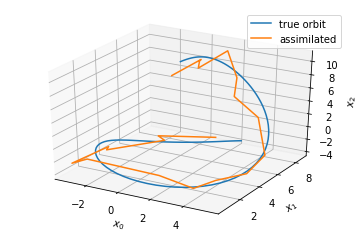

Before assimilation
cost 9974.10166653


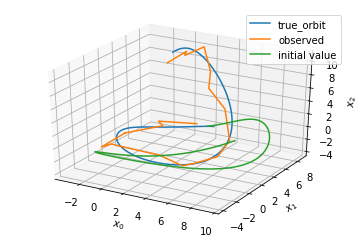

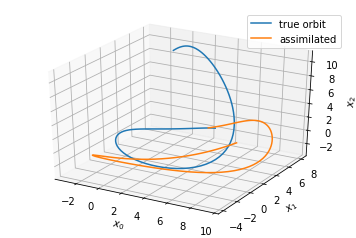

Analytical and numerical gradient comparison
gr_anal [  68.26079211  -26.26996903  -20.6803648   157.84824893 -150.82239627
  219.35142145  271.57424598   87.36705828  -58.07369713  -91.23197223
  121.43225067  -26.1776113   -63.46374805   -8.60052306   68.06853903
 -172.82980078 -131.75846798   31.69388575    3.31752501  125.02417054
   -4.78023209  -29.71306338   77.6181514     7.65090587   50.42861415
  107.17853267   71.27055784  -92.17594065  -46.69146521  197.37682556
   16.32922031  188.86173938  529.2594486   117.49258077  128.35042498
   63.9090577    86.39025558  -20.0105802   -24.58183542  109.76254716]
gr_num [  63.77964322  -27.18747525  -19.38466303  151.45041196 -135.7406464
  195.00023393  234.27570999   77.54444542  -49.10377747  -69.08131364
  119.76965401  -31.97601292  -75.28873141  -14.53810564   81.25280288
 -152.62821041 -111.12969604   34.27901953   11.72513041   85.5739924
    5.60607792   33.46202877   -6.43677157   27.33471121   55.36394321
   90.40634735   3

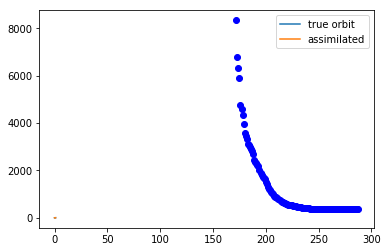

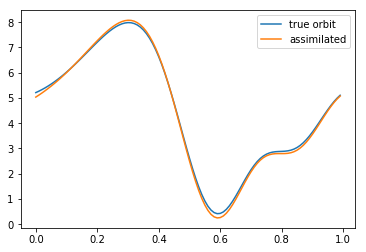

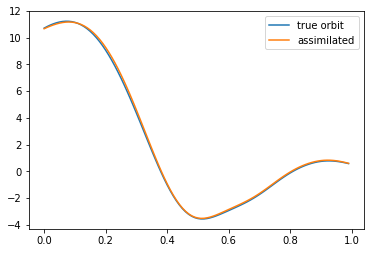

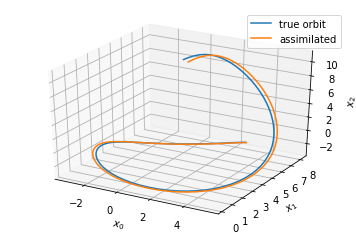

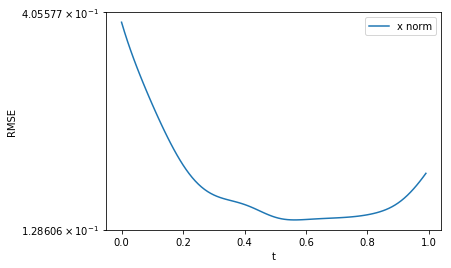

RMSE:  0.147750141838
4DVar optimal cost:  372.803980259
true cost:  388.658669894


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self,x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    mt[j][i] -= 1
        gr = mt @ la
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x

    def nextstep(self):
        k1 = handler(self.callback, self.x)
        k2 = handler(self.callback, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps,N))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        la = np.zeros((self.minute_steps, self.N))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps, self.N))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            la[self.it*i] += self.x[self.it*i] - self.y[i]
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(N)
        c1 = self.cost(x0)
        for j in range(N):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr

    def cbf(self, x0):
        global count, axL, axR
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 40
F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N, F)

tob = np.loadtxt("../data/year.1.dat")

obs = np.loadtxt("../data/observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)

x_opt = np.loadtxt("../data/assimilation_xzero.2.dat")

x = np.zeros((minute_steps,N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs)


print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x)

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

for j in range(3):
#for j in range(N):
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps], scheme.x)

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
print('true cost: ', scheme_true.true_cost())


## パラメータ推定を含む、Strong-constraint 4D-Varコードの作成と双子実験

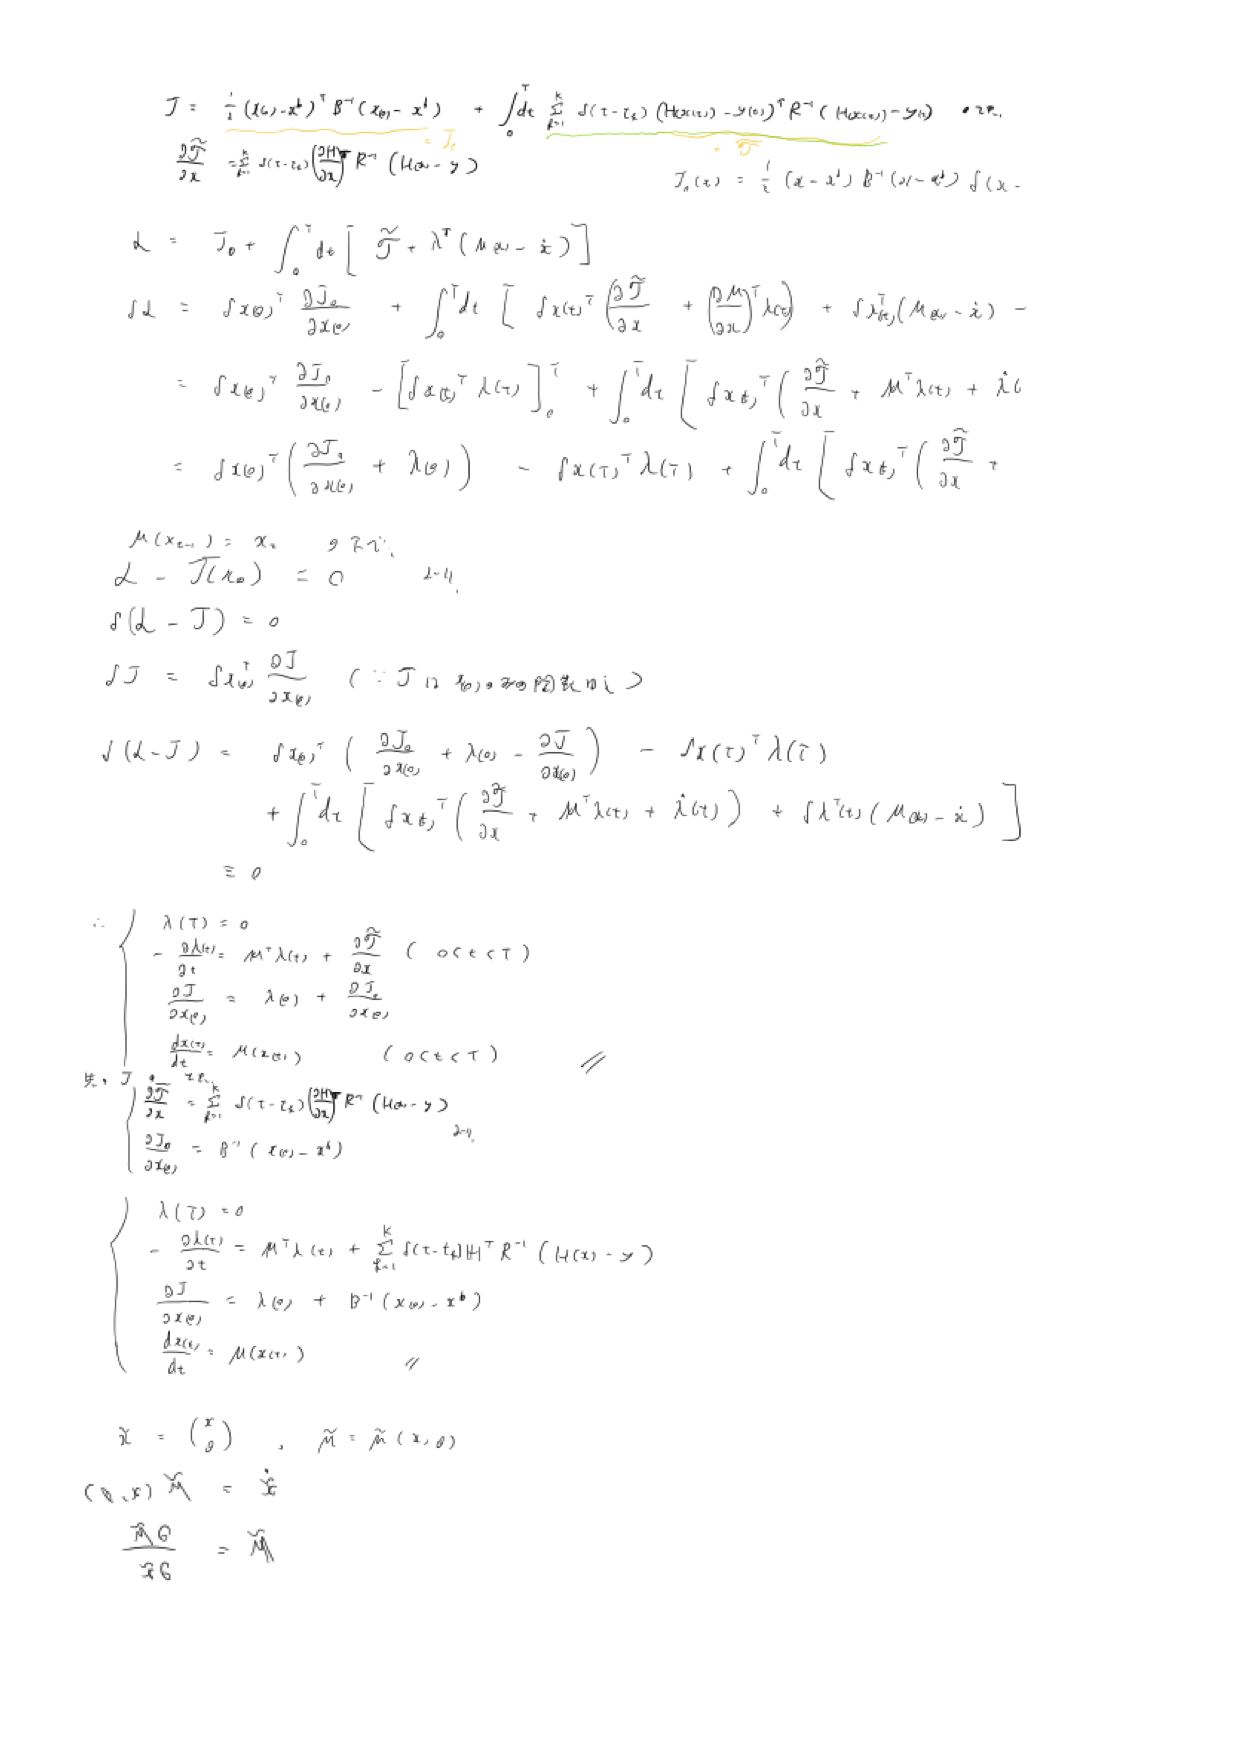

In [4]:
from IPython.display import Image, display_png
display_png(Image("./figs/4DVarParam.png"))

Lorenz96 modelのFを推定する問題

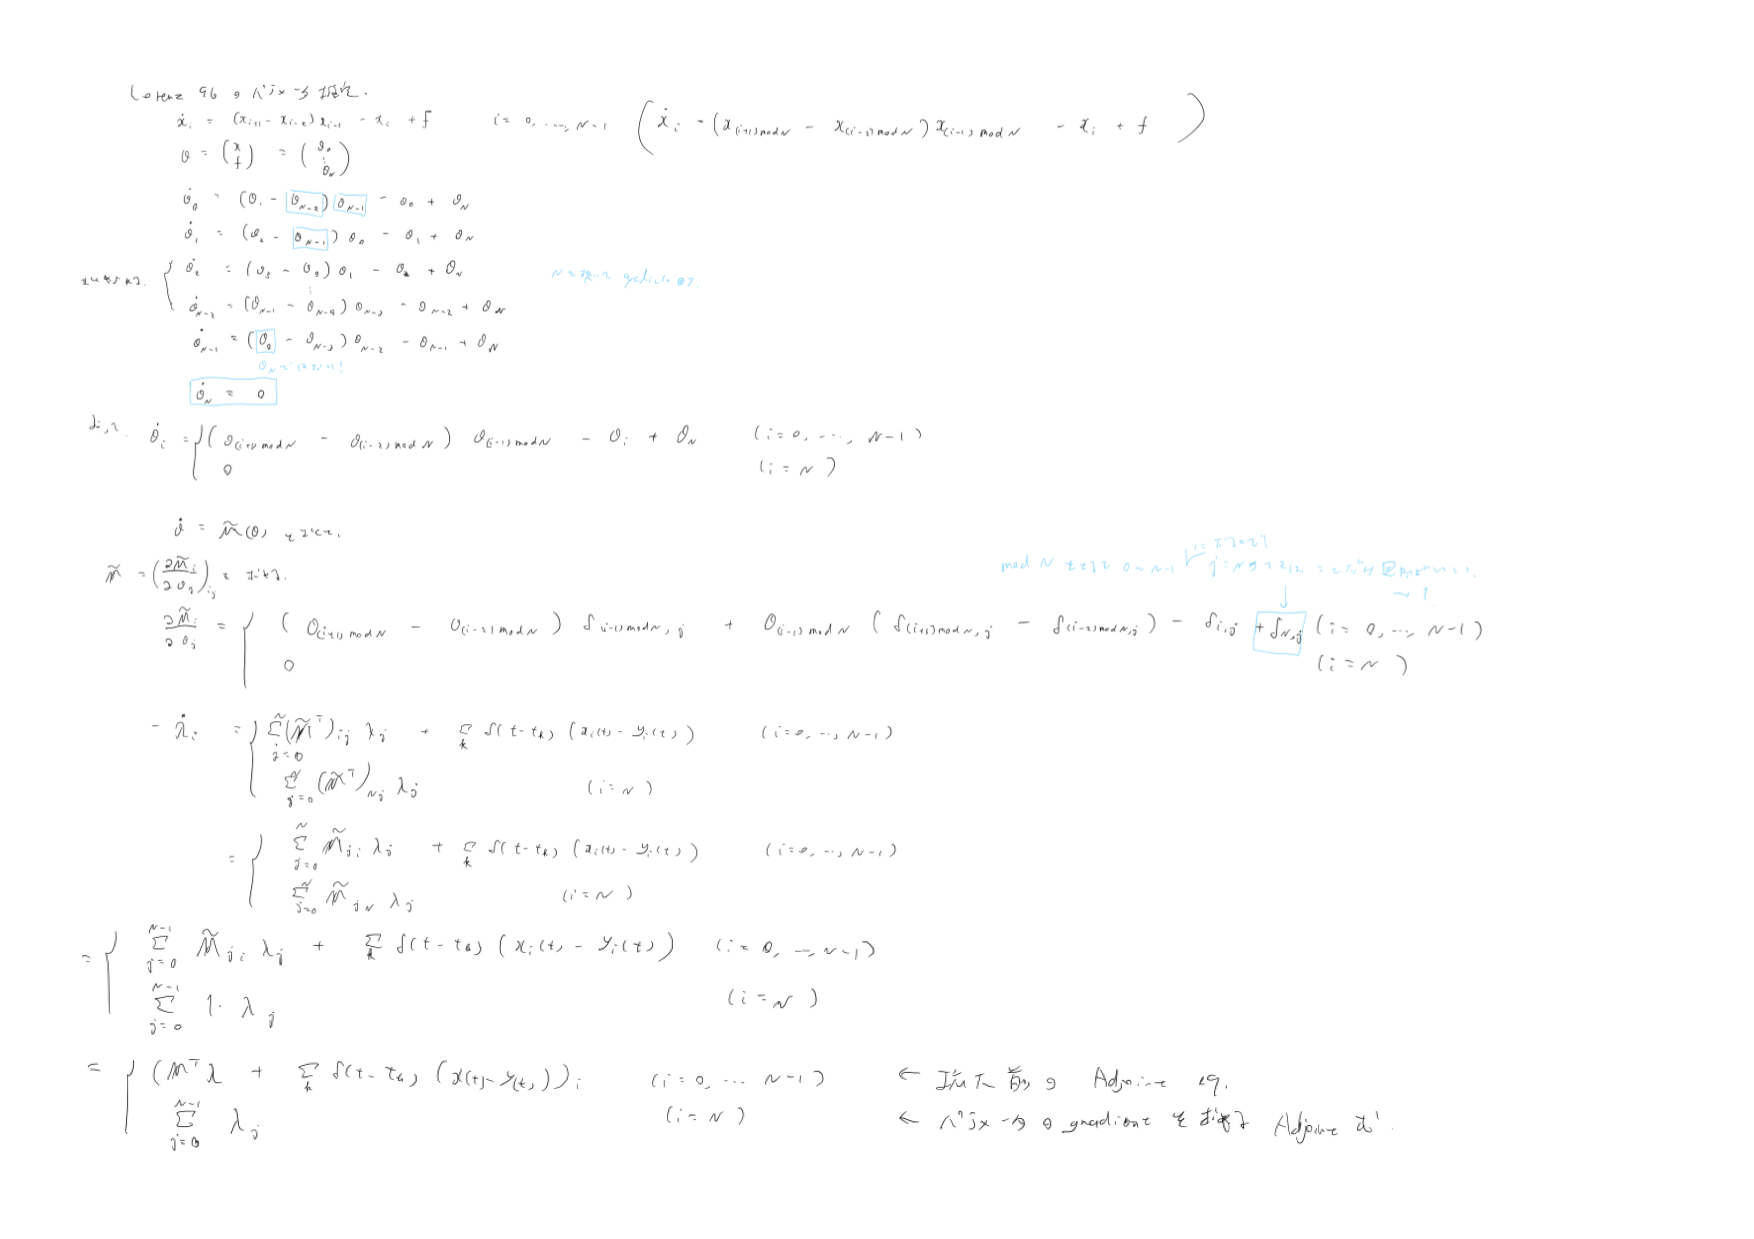

In [6]:
display_png(Image("./figs/4DVarParamLorenz.png"))

T 1.0
day 5.0


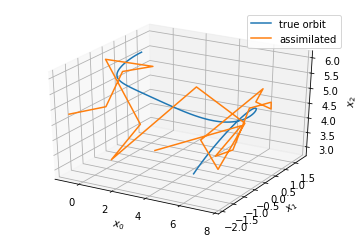

Before assimilation
cost 2400.1603007


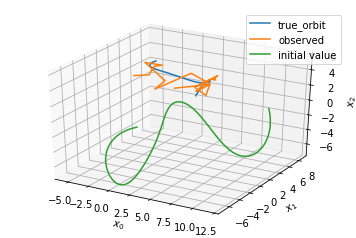

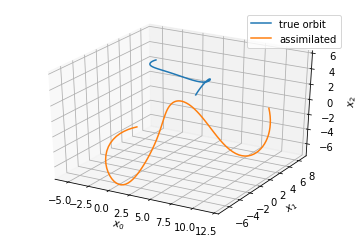

Analytical and numerical gradient comparison
gr_anal [ 133.03601565   94.4570743    56.47065871  255.18685696  -41.54035149
  -20.04358802  220.26898737  234.74396366]
gr_num [ 102.26077225   75.56959263   32.26155477  145.62272663   -1.45000677
   48.05983062  197.65840766  210.47380815]
relative error [  0.30094867   0.24993494   0.75040103   0.75238346  27.64838458
  -1.4170549    0.1143922    0.115312  ]
      fun: 68.827548981242344
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00872776,  0.02303383,  0.00144457, -0.01549293,  0.02115288,
        0.01727762, -0.03785443,  0.03252818])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 55
   status: 0
  success: True
        x: array([ 5.81059205, -0.84743332,  3.65727679,  3.78580376, -1.84901107,
       -0.33482859,  3.03169107,  8.23050353])
true x0 [ 6.400706 -1.873827  3.664105  3.516149 -2.240415 -0.049599  2.28188 ]


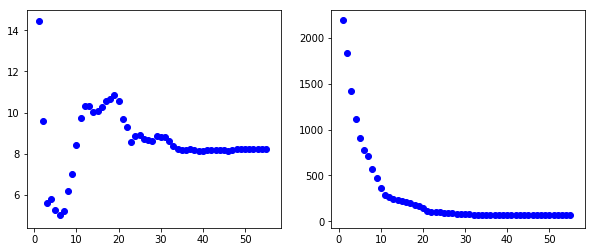

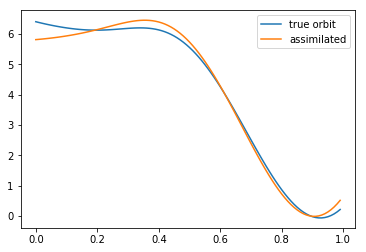

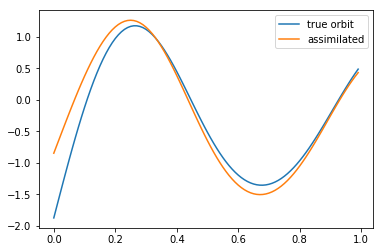

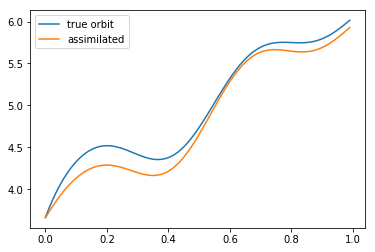

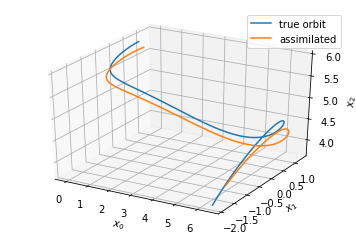

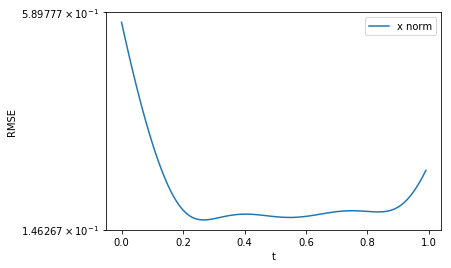

RMSE:  0.174272043357
4DVar optimal cost:  68.8275489812
true cost:  72.9340998081


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

count = 0

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N):
        self.N = N # number of variables
        self.M = 1 # number of parameters
    def gradient(self,x):
        d = np.zeros(self.N + self.M)
        d[0]        = (x[1]   - x[self.N-2]) * x[self.N-1] - x[0]        + x[self.N]
        d[1]        = (x[2]   - x[self.N-1]) * x[0]        - x[1]        + x[self.N]
        for i in range(2, self.N-1):
            d[i]    = (x[i+1] - x[i-2])      * x[i-1]      - x[i]        + x[self.N]
        d[self.N-1] = (x[0]   - x[self.N-3]) * x[self.N-2] - x[self.N-1] + x[self.N]
        d[self.N] = 0
        return d
        
    def gradient_adjoint(self, la, x):
        mt = np.zeros((self.N + self.M ,self.N + self.M))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == j):
                    mt[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == j):
                    mt[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == j):
                    mt[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == j):
                    mt[j][i] -= 1
            mt[N][i] = 1
#        for j in range(self.N + self.M):
#            mt[j][self.N] = 0             # not needed because mt is initiated as zero
        gr = mt @ la
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x
        self.M = 1

    def nextstep(self):
        k1 = handler(self.callback, self.x)
        k2 = handler(self.callback, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N + self.M))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps, self.N + self.M))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr

class Adjoint:
    def __init__(self, dx, dla, N, T, dt, it, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.M = 1
        
    def orbit(self):
        for i in range(self.minute_steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        for i in range(self.steps):
            for j in range(self.N):
                self.x[i,j] += stddev * np.random.randn() # fixed
        return tob, self.x
    
    def gradient(self):
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6            
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.minute_steps, self.N + self.M))
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                if (n < self.it*self.steps - 1):
                    p1 = handler(self.dx, self.x[n])
                    p2 = handler(self.dx, self.x[n] + p1*self.dt/2)
                    p3 = handler(self.dx, self.x[n] + p2*self.dt/2)
                    p4 = handler(self.dx, self.x[n] + p3*self.dt)
                    gr = (p1 + 2*p2 + 2*p3 + p4)/6
    
                    k1 = handler(self.dla, la[n+1], self.x[n+1])
                    k2 = handler(self.dla, la[n+1] - k1*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k3 = handler(self.dla, la[n+1] - k2*self.dt/2, self.x[n+1] - gr*self.dt/2)
                    k4 = handler(self.dla, la[n+1] - k3*self.dt, self.x[n])
                    la[n] = la[n+1] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
            for j in range(self.N):
                la[self.it*i][j] += self.x[self.it*i][j] - self.y[i][j]
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(self.N + self.M)
        c1 = self.cost(x0)
        for j in range(self.N + self.M):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr
    
    def cbf(self, x0):
        global count, axL, axR
        count += 1
        axL.scatter(count, x0[self.N], c='b')
        axR.scatter(count, self.cost(x0), c='b')

#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
pref = "../data/" + str(N) + "/"

M = 1
F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1

lorenz = Lorenz96(N)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)

x_opt = np.zeros(N + M)
x_opt[0:N] = np.loadtxt(pref + "year.2.dat")[np.random.randint(len(tob))]
x_opt[N] = 15 # initial guess for F

x = np.zeros((minute_steps, N + M))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, x, obs)

print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps], obs[0:steps], scheme.x[:,0:N], 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.00001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
global axL
global axR
fig , (axL, axR) = plt.subplots(ncols=2, figsize=(10,4), sharex=False)
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
print (res)
print ("true x0", tob[0])

for j in range(3):
#for j in range(N):
    fig = plt.figure()
    plt.plot(t, tob[0:minute_steps,j], label='true orbit')
    plt.plot(t, scheme.x[0:minute_steps,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps], scheme.x[:,0:N])

#%%
fig = plt.figure()
plt.plot(t, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))]))

print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, it, tob, obs)
print('true cost: ', scheme_true.true_cost())


## systems biologyにおける、ヒル式的活性化反応のcontrol variableと、パラメータ推定を含むStrong-constraint 4D-Varの導出

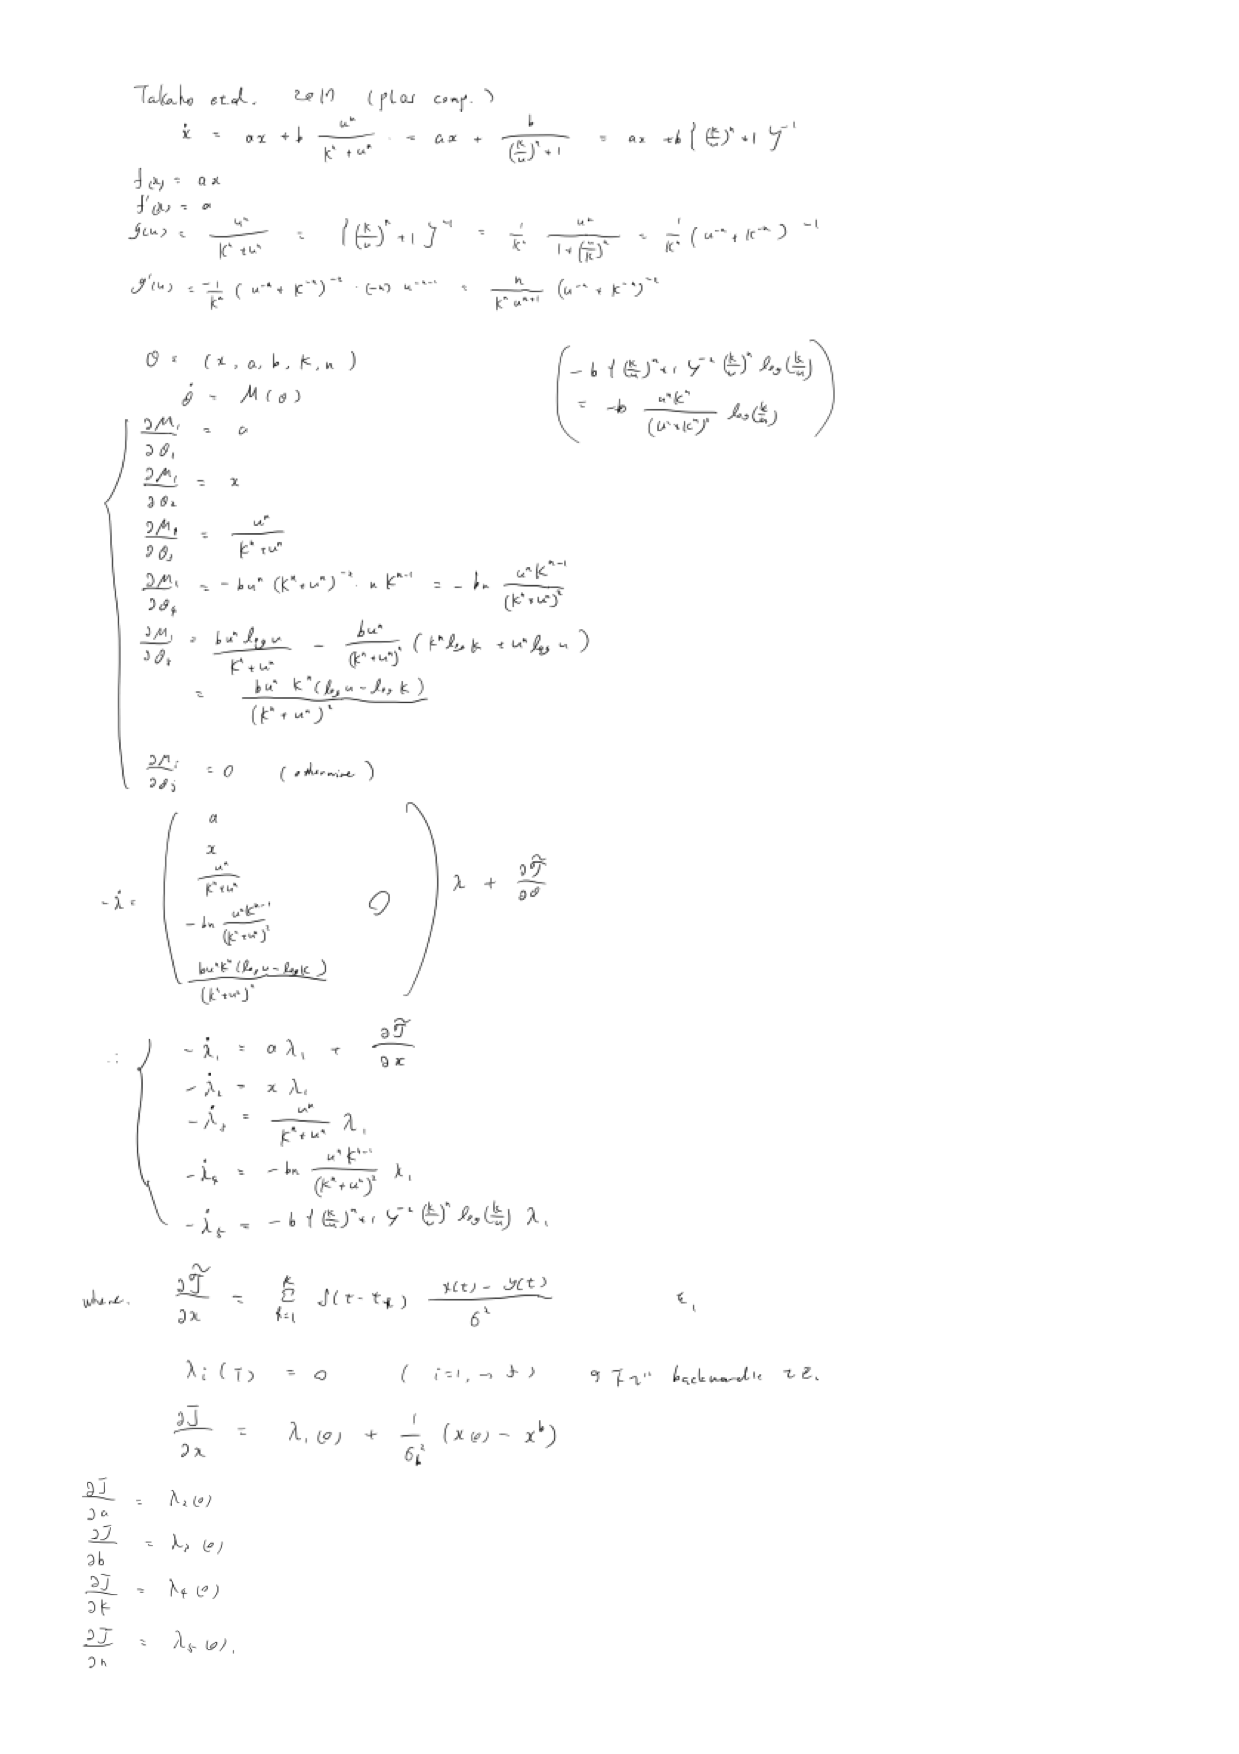

In [11]:
display_png(Image("./figs/4DVarParamHill.png"))

## Weak-constraint 4D-Varの導出

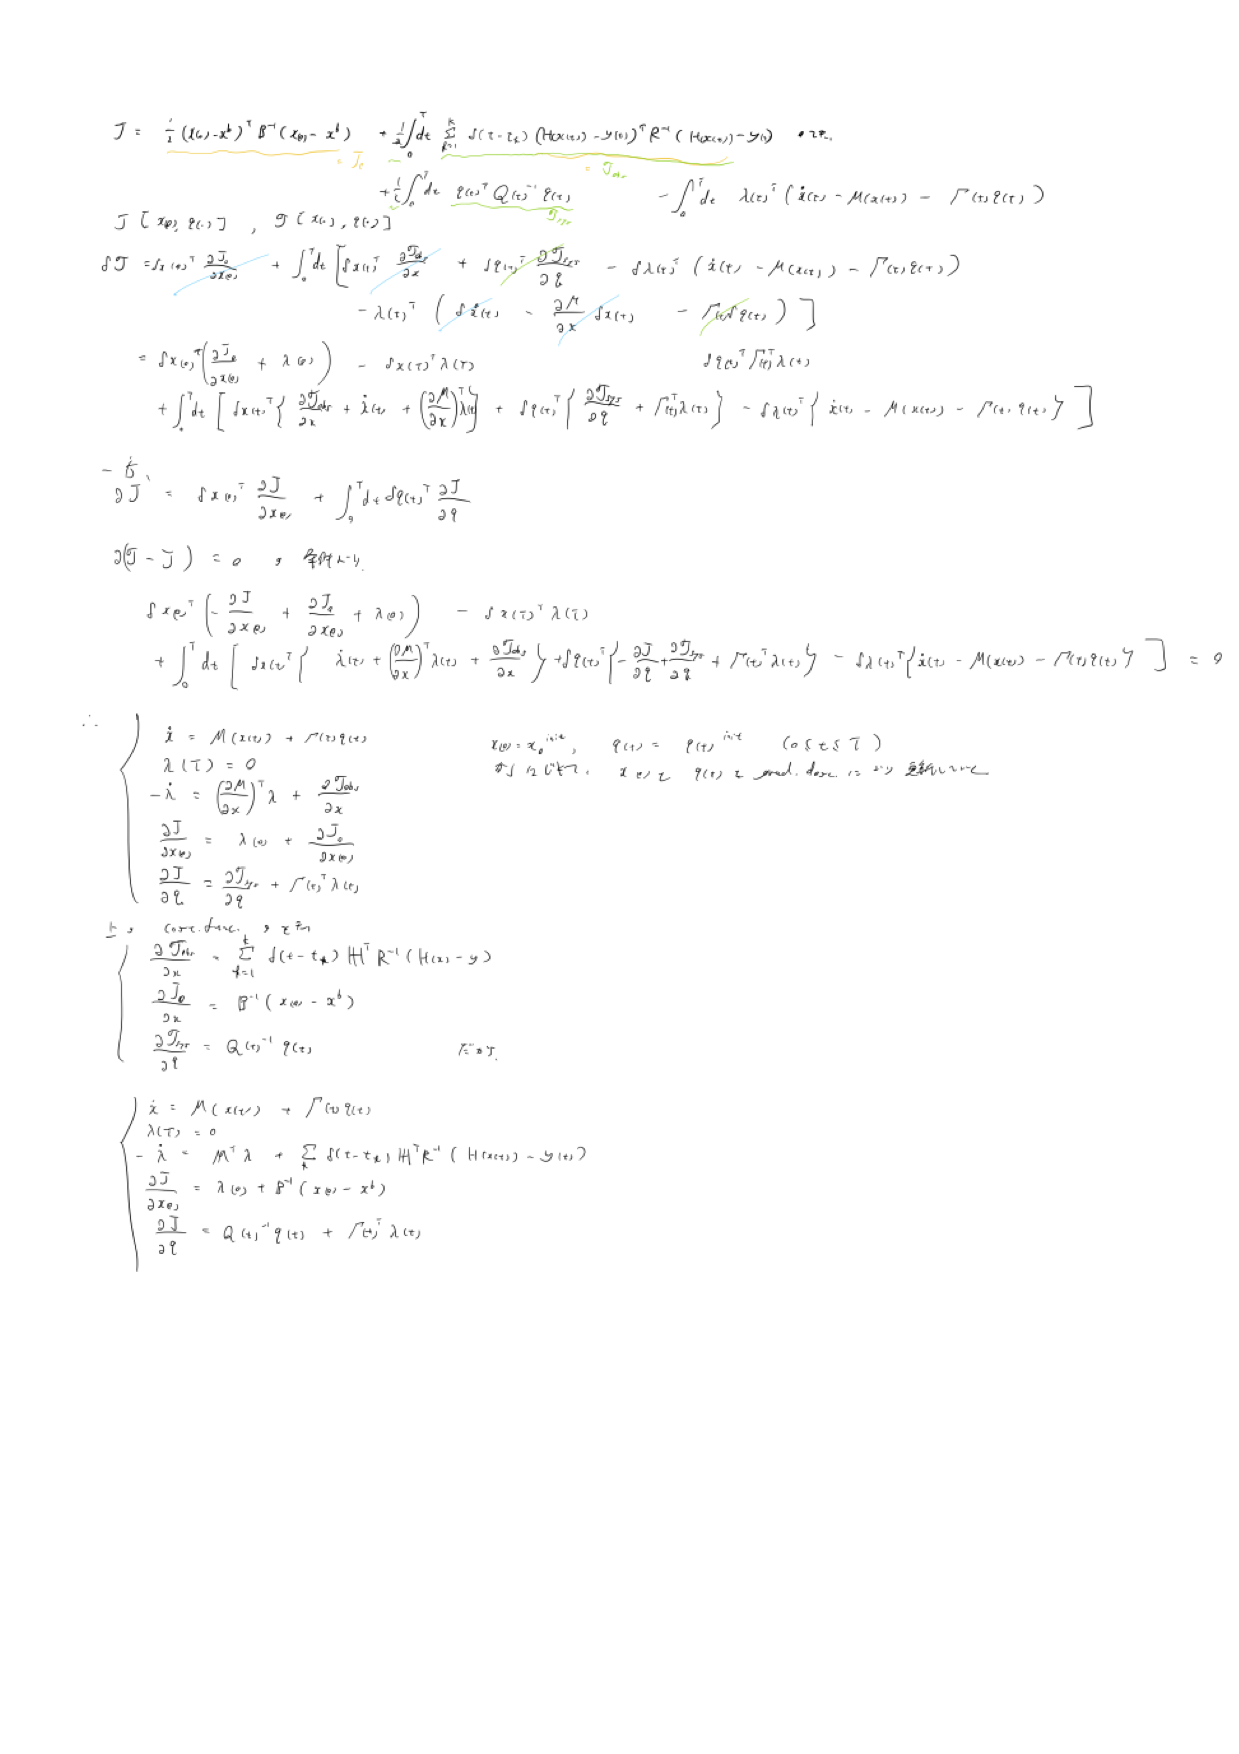

In [13]:
display_png(Image("./figs/4DVarWeak.png"))

## Weak-constraint 4D-Varと、システムノイズありの固定区間スムーザーの等価性の証明

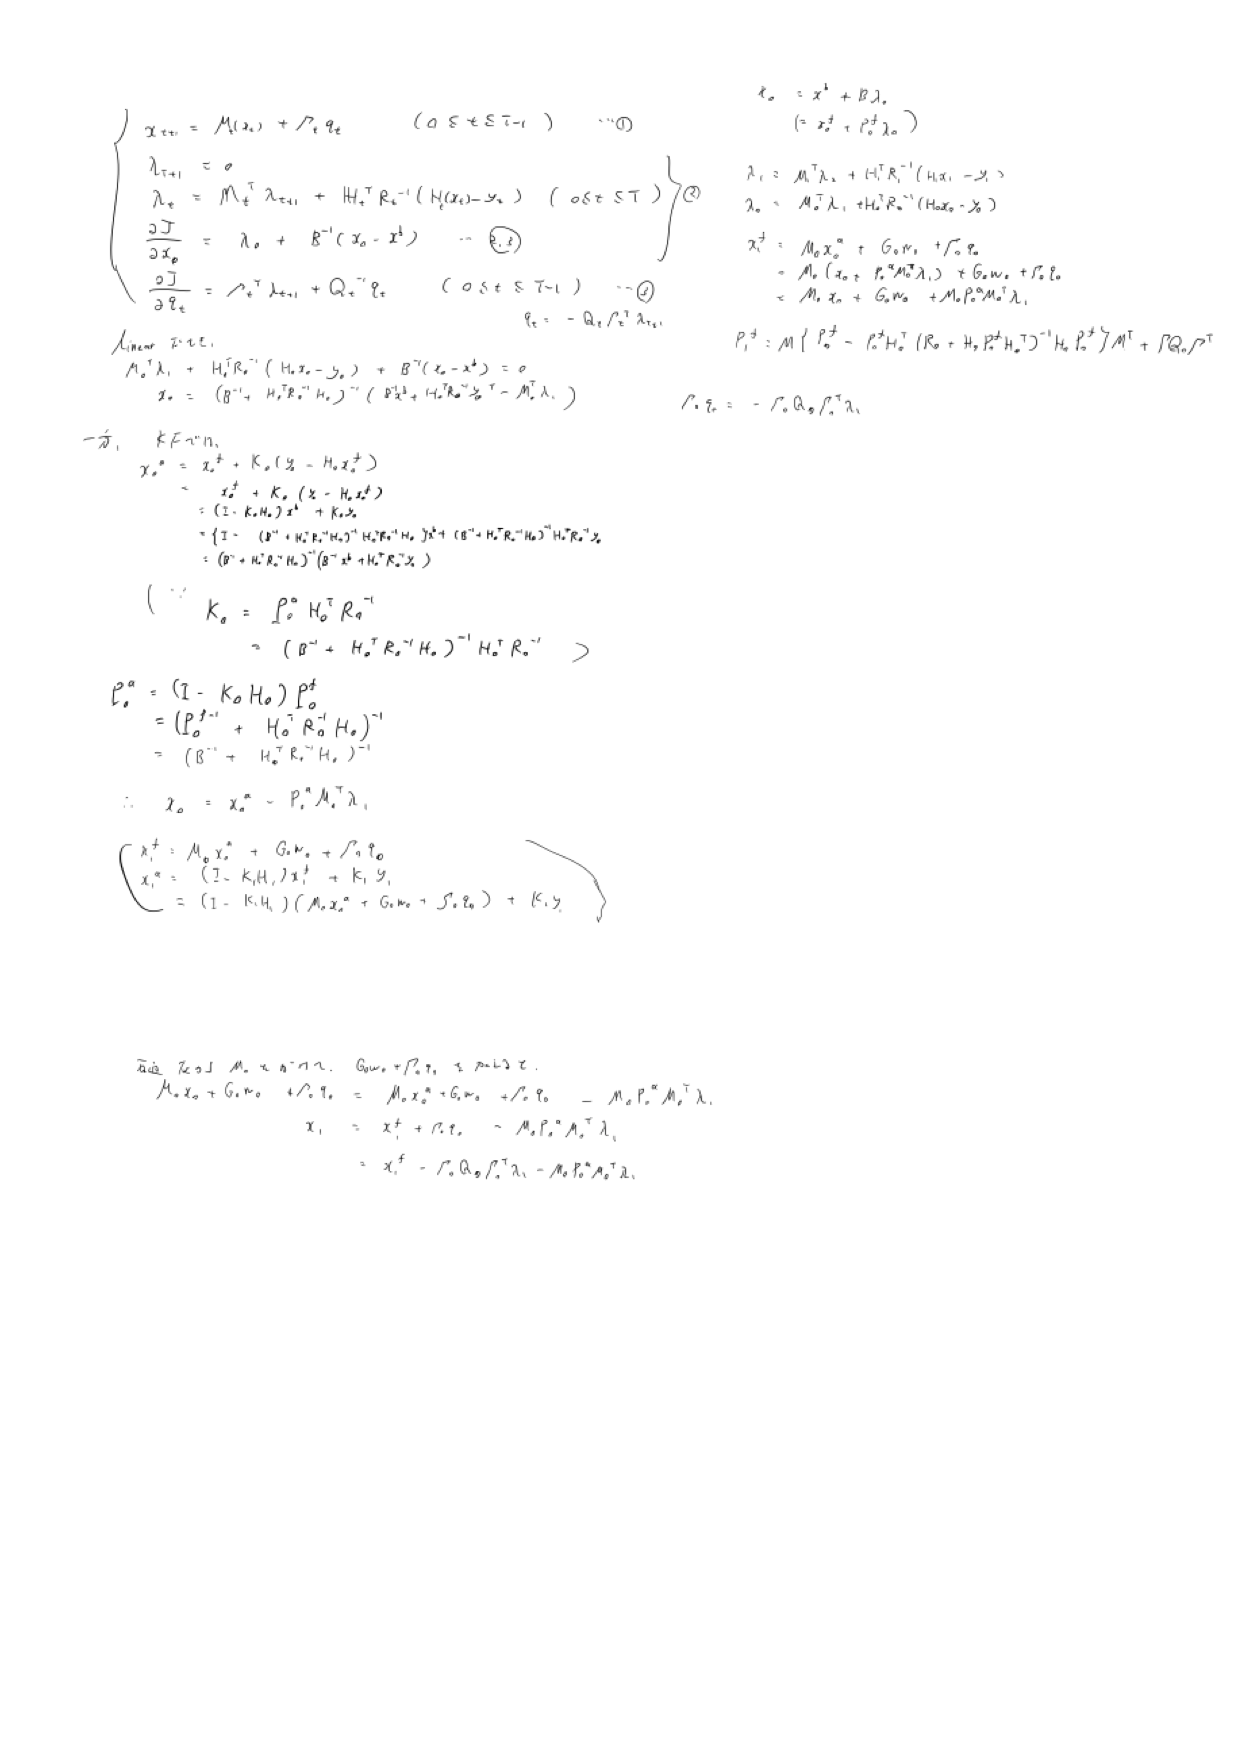

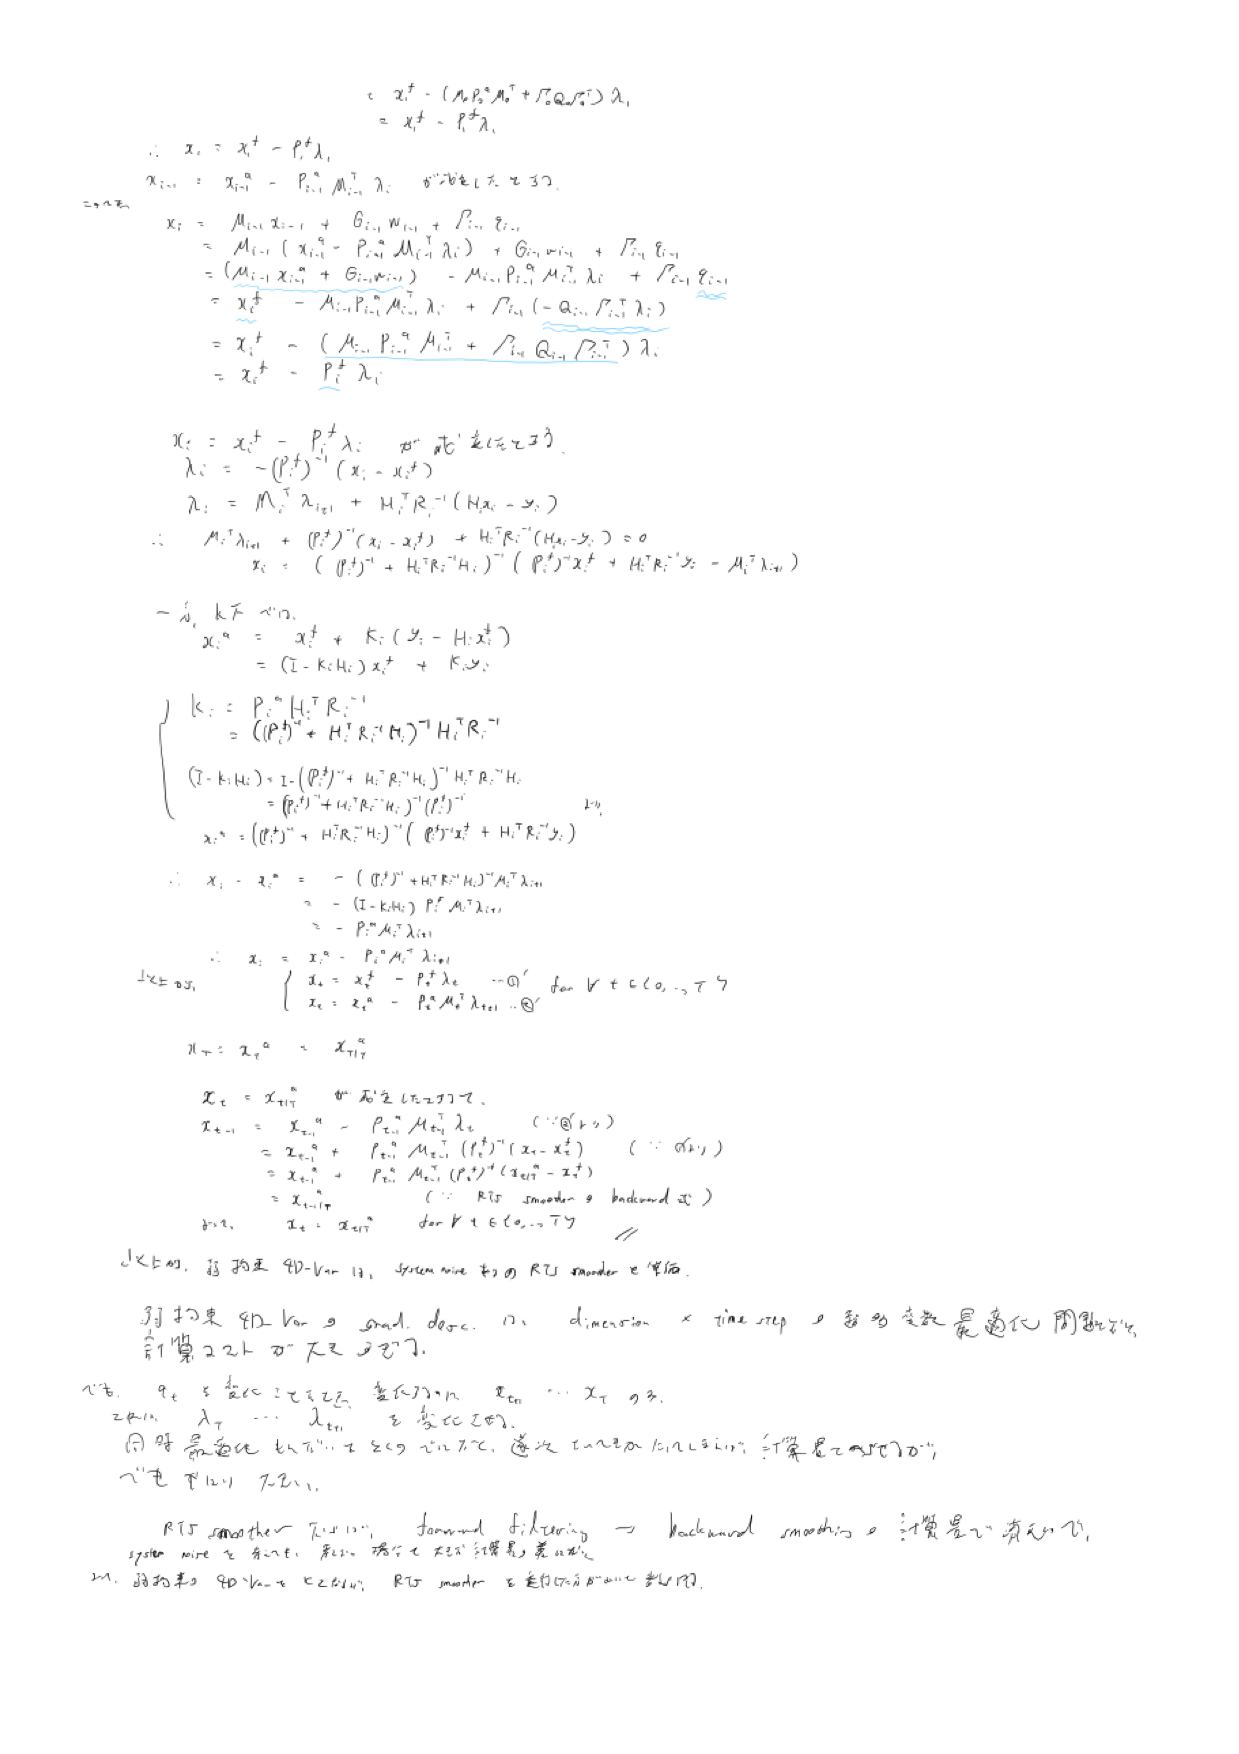

In [14]:
display_png(Image("./figs/4DVarWeakRTS1.png"))
display_png(Image("./figs/4DVarWeakRTS2.png"))

## Strong-constraint 4D-Varと、システムノイズなしの固定区間スムーザーの等価性の証明

Weak-constraint 4D-Varで$q$の式がなくなるのと、システムノイズなしの固定区間スムーザーでは共分散行列のforcast stepで$\Gamma Q \Gamma^{\mathrm{T}}$がなくなることを考え合わせれば、上と同様にして示せる。

システムノイズを考慮したデータ同化を4DVarとして実装する場合は、Weak-constraintにすると、(状態の次元) x (時間ステップ)の超多変数のgradient descentを解くことになるので、厳しい。

その場合には固定区間スムーザーとして実装する方が良いと考えられる。（ただし、非線形問題は、Extended Kalman Smootherとして近似するしかない。）

# 来週の目標
- systems biologyにおける、ヒル式的活性化反応のcontrol variableと、パラメータ推定を含むStrong-constraint 4D-Varコードの作成と双子実験
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装